# Bloque III – Filtrado y depuración

In [38]:
import glob
import json
import os
from pathlib import Path
import re
from typing import List
import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.metrics.distance import edit_distance
from sentence_transformers import SentenceTransformer, util

## Métricas

In [39]:
def normalizar_predicado(p):
    return p.replace("_", " ").lower().strip()

In [40]:
def evaluate_structural_similarity_ST(baseline_path, gold_path, threshold=0.8, verbose=False):
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device="cpu")

    def load_graph(filepath):
        df = pd.read_csv(filepath, sep=';')
        df['predicado'] = df['predicado'].apply(normalizar_predicado)
        nodes = set(df['sujeto']).union(df['objeto'])
        edges = set([tuple(x) for x in df[['sujeto', 'predicado', 'objeto']].values])
        return df, nodes, edges

    def map_entities(pred_entities, gold_entities, model, threshold=0.8):
        pred_list = list(pred_entities)
        gold_list = list(gold_entities)
        pred_emb = model.encode(pred_list, convert_to_tensor=True)
        gold_emb = model.encode(gold_list, convert_to_tensor=True)
        sim_matrix = util.pytorch_cos_sim(pred_emb, gold_emb)
        mapping = {}
        matches = []
        used_gold_nodes = set()
        for i, sims in enumerate(sim_matrix):
            best_score, best_j = sims.max(0)
            if best_score >= threshold:
                pred_term = pred_list[i]
                gold_term = gold_list[best_j.item()]
                if gold_term not in used_gold_nodes:
                    mapping[pred_term] = gold_term
                    used_gold_nodes.add(gold_term)
                    matches.append((pred_term, gold_term, float(best_score)))
                else:
                    mapping[pred_term] = pred_term
            else:
                mapping[pred_list[i]] = pred_list[i]
        return mapping, matches

    def map_edges(pred_edges, gold_edges, model, entity_mapping, threshold=0.8):
        mapped_edges = set()
        gold_edge_list = list(gold_edges)
        matches = []
        used_gold_edges = set()
        for s, p, o in pred_edges:
            s_m = entity_mapping.get(s, s)
            o_m = entity_mapping.get(o, o)
            p_emb = model.encode(p, convert_to_tensor=True)
            found = False
            for gold_s, gold_p, gold_o in gold_edge_list:
                if (gold_s, gold_p, gold_o) in used_gold_edges:
                    continue
                if entity_mapping.get(gold_s, gold_s) != s_m:
                    continue
                if entity_mapping.get(gold_o, gold_o) != o_m:
                    continue
                gold_p_emb = model.encode(gold_p, convert_to_tensor=True)
                sim = util.pytorch_cos_sim(p_emb, gold_p_emb).item()
                if sim >= threshold:
                    mapped_edges.add((s_m, gold_p, o_m))
                    used_gold_edges.add((gold_s, gold_p, gold_o))
                    matches.append(((s, p, o), (gold_s, gold_p, gold_o), float(sim)))
                    found = True
                    break
            if not found:
                mapped_edges.add((s_m, p, o_m))
        return mapped_edges, matches

    df_pred, nodes_pred, edges_pred = load_graph(baseline_path)
    df_gold, nodes_gold, edges_gold = load_graph(gold_path)

    if verbose:
        print("📥 Mapeando nodos...")

    node_mapping, node_matches = map_entities(nodes_pred, nodes_gold, model, threshold)

    if verbose:
        print("📥 Mapeando aristas...")

    mapped_edges, edge_matches = map_edges(edges_pred, edges_gold, model, node_mapping, threshold)
    mapped_nodes = {node_mapping[n] for n in nodes_pred}

    nodes_pred_set = set(mapped_nodes)
    nodes_gold_set = set(nodes_gold)
    edges_pred_set = set(mapped_edges)
    edges_gold_set = set(edges_gold)

    node_inter = nodes_pred_set & nodes_gold_set
    edge_inter = edges_pred_set & edges_gold_set
    node_union = nodes_pred_set | nodes_gold_set
    edge_union = edges_pred_set | edges_gold_set

    similarity = (len(node_inter) + len(edge_inter)) / (len(node_union) + len(edge_union)) if (len(node_union) + len(edge_union)) > 0 else 0.0

    if verbose:
        print("\n✅ Nodos mapeados (pred → gold):")
        for pred, gold, score in node_matches:
            print(f"  {pred} → {gold} (sim={score:.4f})")

        print("\n✅ Aristas mapeadas (pred → gold):")
        for pred_triple, gold_triple, score in edge_matches:
            print(f"  {pred_triple} → {gold_triple} (sim={score:.4f})")

        print(f"\n🧠 Nodos en común ({len(node_inter)}):")
        for n in node_inter:
            print(f"  ✔ {n}")

        print(f"\n➖ Nodos solo en pred ({len(nodes_pred_set - nodes_gold_set)}):")
        for n in nodes_pred_set - nodes_gold_set:
            print(f"  ✖ {n}")

        print(f"\n➖ Nodos solo en gold ({len(nodes_gold_set - nodes_pred_set)}):")
        for n in nodes_gold_set - nodes_pred_set:
            print(f"  ✖ {n}")

        print(f"\n🔗 Aristas en común ({len(edge_inter)}):")
        for e in edge_inter:
            print(f"  ✔ {e}")

        print(f"\n➖ Aristas solo en pred ({len(edges_pred_set - edges_gold_set)}):")
        for e in edges_pred_set - edges_gold_set:
            print(f"  ✖ {e}")

        print(f"\n➖ Aristas solo en gold ({len(edges_gold_set - edges_pred_set)}):")
        for e in edges_gold_set - edges_pred_set:
            print(f"  ✖ {e}")

        print(f"\n📊 Similitud estructural final: {similarity:.4f}")

    return {
      "nodos_en_comun": len(node_inter),
      "aristas_en_comun": len(edge_inter),
      "nodos_totales": len(node_union),
      "aristas_totales": len(edge_union),
      "similitud_estructural": similarity,
      "nodos_pred": nodes_pred_set,
      "nodos_gold": nodes_gold_set,
      "nodos_match": node_inter,
      "aristas_pred": edges_pred_set,
      "aristas_gold": edges_gold_set,
      "aristas_match": edge_inter,
  }

In [41]:
def evaluate_structural_similarity_levenshtein(baseline_path, gold_path, max_distance=2, verbose=False):
    def load_graph(filepath):
        df = pd.read_csv(filepath, sep=';')
        df['predicado'] = df['predicado'].apply(normalizar_predicado)
        nodes = set(df['sujeto']).union(df['objeto'])
        edges = set([tuple(x) for x in df[['sujeto', 'predicado', 'objeto']].values])
        return df, nodes, edges

    def map_entities(pred_entities, gold_entities, max_distance):
        mapping = {}
        matches = []
        used_gold = set()
        for pred in pred_entities:
            best_match = pred
            best_score = float('inf')
            for gold in gold_entities:
                dist = edit_distance(pred.lower(), gold.lower())
                if dist <= max_distance and dist < best_score and gold not in used_gold:
                    best_match = gold
                    best_score = dist
            mapping[pred] = best_match
            if best_match != pred:
                used_gold.add(best_match)
                matches.append((pred, best_match, best_score))
        return mapping, matches

    def map_edges(pred_edges, gold_edges, entity_mapping, max_distance):
        mapped_edges = set()
        used_gold_edges = set()
        matches = []
        for s, p, o in pred_edges:
            s_m = entity_mapping.get(s, s)
            o_m = entity_mapping.get(o, o)
            found = False
            for gs, gp, go in gold_edges:
                if gs != s_m or go != o_m or (gs, gp, go) in used_gold_edges:
                    continue
                dist = edit_distance(p.lower(), gp.lower())
                if dist <= max_distance:
                    mapped_edges.add((s_m, gp, o_m))
                    used_gold_edges.add((gs, gp, go))
                    matches.append(((s, p, o), (gs, gp, go), dist))
                    found = True
                    break
            if not found:
                mapped_edges.add((s_m, p, o_m))
        return mapped_edges, matches

    df_pred, nodes_pred, edges_pred = load_graph(baseline_path)
    df_gold, nodes_gold, edges_gold = load_graph(gold_path)

    if verbose:
        print("📥 Mapeando nodos...")

    node_mapping, node_matches = map_entities(nodes_pred, nodes_gold, max_distance)

    if verbose:
        print("📥 Mapeando aristas...")

    mapped_edges, edge_matches = map_edges(edges_pred, edges_gold, node_mapping, max_distance)
    mapped_nodes = {node_mapping[n] for n in nodes_pred}

    nodes_pred_set = set(mapped_nodes)
    nodes_gold_set = set(nodes_gold)
    edges_pred_set = set(mapped_edges)
    edges_gold_set = set(edges_gold)

    node_inter = nodes_pred_set & nodes_gold_set
    edge_inter = edges_pred_set & edges_gold_set
    node_union = nodes_pred_set | nodes_gold_set
    edge_union = edges_pred_set | edges_gold_set

    similarity = (len(node_inter) + len(edge_inter)) / (len(node_union) + len(edge_union)) if (len(node_union) + len(edge_union)) > 0 else 0.0

    if verbose:
        print("\n✅ Nodos mapeados (pred → gold):")
        for pred, gold, dist in node_matches:
            print(f"  {pred} → {gold} (dist={dist})")

        print("\n✅ Aristas mapeadas (pred → gold):")
        for pred_triple, gold_triple, dist in edge_matches:
            print(f"  {pred_triple} → {gold_triple} (dist={dist})")

        print(f"\n🧠 Nodos en común ({len(node_inter)}):")
        for n in node_inter:
            print(f"  ✔ {n}")

        print(f"\n➖ Nodos solo en pred ({len(nodes_pred_set - nodes_gold_set)}):")
        for n in nodes_pred_set - nodes_gold_set:
            print(f"  ✖ {n}")

        print(f"\n➖ Nodos solo en gold ({len(nodes_gold_set - nodes_pred_set)}):")
        for n in nodes_gold_set - nodes_pred_set:
            print(f"  ✖ {n}")

        print(f"\n🔗 Aristas en común ({len(edge_inter)}):")
        for e in edge_inter:
            print(f"  ✔ {e}")

        print(f"\n➖ Aristas solo en pred ({len(edges_pred_set - edges_gold_set)}):")
        for e in edges_pred_set - edges_gold_set:
            print(f"  ✖ {e}")

        print(f"\n➖ Aristas solo en gold ({len(edges_gold_set - edges_pred_set)}):")
        for e in edges_gold_set - edges_pred_set:
            print(f"  ✖ {e}")

        print(f"\n📊 Similitud estructural final: {similarity:.4f}")

    return {
      "nodos_en_comun": len(node_inter),
      "aristas_en_comun": len(edge_inter),
      "nodos_totales": len(node_union),
      "aristas_totales": len(edge_union),
      "similitud_estructural": similarity,
      "nodos_pred": nodes_pred_set,
      "nodos_gold": nodes_gold_set,
      "nodos_match": node_inter,
      "aristas_pred": edges_pred_set,
      "aristas_gold": edges_gold_set,
      "aristas_match": edge_inter,
  }

In [42]:
def calculate_accuracy_ST(gold_path, generated_path, threshold=0.8):
    results = evaluate_structural_similarity_ST(generated_path, gold_path, threshold)
    edge_accuracy = len(results["aristas_match"]) / len(results["aristas_pred"]) if results["aristas_pred"] else 0.0
    node_accuracy = len(results["nodos_match"]) / len(results["nodos_pred"]) if results["nodos_pred"] else 0.0
    return (edge_accuracy + node_accuracy) / 2

def calculate_recall_ST(gold_path, generated_path, threshold=0.8):
    results = evaluate_structural_similarity_ST(generated_path, gold_path, threshold)
    edge_recall = len(results["aristas_match"]) / len(results["aristas_gold"]) if results["aristas_gold"] else 0.0
    node_recall = len(results["nodos_match"]) / len(results["nodos_gold"]) if results["nodos_gold"] else 0.0
    return (edge_recall + node_recall) / 2

In [43]:
def calculate_accuracy_levenshtein(gold_path, generated_path, max_distance=2):
    results = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance)
    edge_accuracy = len(results["aristas_match"]) / len(results["aristas_pred"]) if results["aristas_pred"] else 0.0
    node_accuracy = len(results["nodos_match"]) / len(results["nodos_pred"]) if results["nodos_pred"] else 0.0
    return (edge_accuracy + node_accuracy) / 2

def calculate_recall_levenshtein(gold_path, generated_path, max_distance=2):
    results = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance)
    edge_recall = len(results["aristas_match"]) / len(results["aristas_gold"]) if results["aristas_gold"] else 0.0
    node_recall = len(results["nodos_match"]) / len(results["nodos_gold"]) if results["nodos_gold"] else 0.0
    return (edge_recall + node_recall) / 2

In [44]:
def evaluar_grafo(gold_path, generated_path, version_name, threshold_st=0.8, max_dist_lev=2):
    acc_st = calculate_accuracy_ST(gold_path, generated_path, threshold=threshold_st)
    recall_st = calculate_recall_ST(gold_path, generated_path, threshold=threshold_st)
    f1_st = (2 * acc_st * recall_st) / (acc_st + recall_st) if (acc_st + recall_st) > 0 else 0.0

    acc_lev = calculate_accuracy_levenshtein(gold_path, generated_path, max_distance=max_dist_lev)
    recall_lev = calculate_recall_levenshtein(gold_path, generated_path, max_distance=max_dist_lev)
    f1_lev = (2 * acc_lev * recall_lev) / (acc_lev + recall_lev) if (acc_lev + recall_lev) > 0 else 0.0

    jaccard_st = evaluate_structural_similarity_ST(generated_path, gold_path, threshold=threshold_st)["similitud_estructural"]
    jaccard_lev = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance=max_dist_lev)["similitud_estructural"]

    df = pd.DataFrame([{
        "versión": version_name,
        "accuracy_ST": acc_st,
        "accuracy_Levenshtein": acc_lev,
        "recall_ST": recall_st,
        "recall_Levenshtein": recall_lev,
        "f1_ST": f1_st,
        "f1_Levenshtein": f1_lev,
        "jaccard_ST": jaccard_st,
        "jaccard_Levenshtein": jaccard_lev
    }])

    return df

In [45]:
def plot_comparison_bars(df, title, colors=None):

    metrics = ["accuracy_ST", "accuracy_Levenshtein",
               "recall_ST", "recall_Levenshtein",
               "f1_ST", "f1_Levenshtein",
               "jaccard_ST", "jaccard_Levenshtein"]

    labels = ["Acc ST", "Acc Lev",
              "Rec ST", "Rec Lev",
              "F1 ST", "F1 Lev",
              "Jac ST", "Jac Lev"]

    versions = df["versión"].tolist()
    n_versions = len(versions)
    x = np.arange(len(metrics))
    width = 0.8 / n_versions

    default_colors = ['#ff7f0e', '#1f77b4', '#d62728', '#9467bd',
                      '#2ca02c', '#f0e442', '#e377c2', '#7f7f7f',
                      '#8c564b', '#17becf', '#bcbd22', '#393b79']

    if colors is None:
        colors = default_colors

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, version in enumerate(versions):
        values = [df.loc[i, m] for m in metrics]
        positions = x - 0.4 + width/2 + i * width
        bars = ax.bar(
            positions, values, width,
            label=version,
            color=colors[i % len(colors)],
            edgecolor='black',
            alpha=0.85
        )
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h + 0.01, f"{h:.2f}",
                    ha='center', va='bottom', fontsize=9)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=10, fontweight='medium', rotation=25)
    max_val = max(df[metrics].max())
    ax.set_ylim(0, max_val * 1.50)
    ax.set_ylabel("Metric Value", fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)
    ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax.set_axisbelow(True)
    ax.legend(frameon=False, fontsize=11, loc='upper right')
    plt.tight_layout()
    plt.show()

## Estrategia 6: Filtrado de tripletas por confianza   

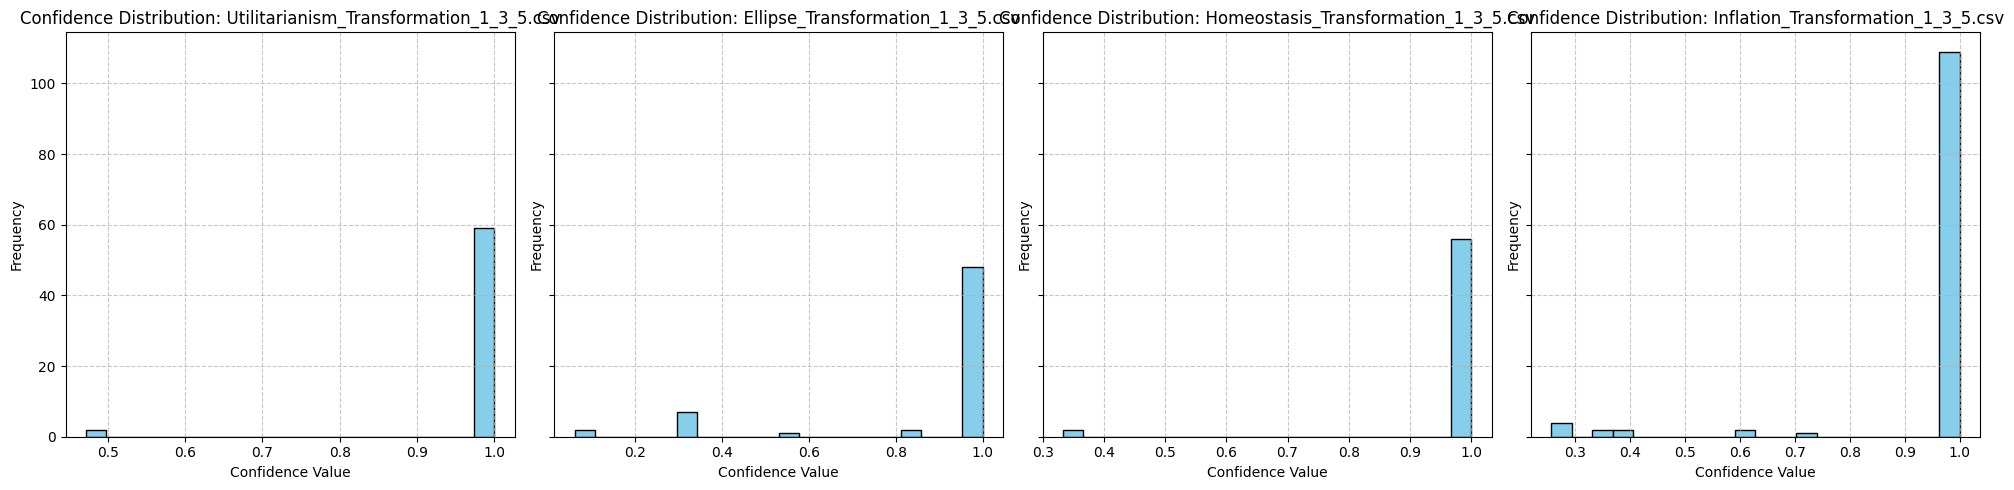

In [46]:
# Visualizar histogramas de las distribuciones de valores de confianza

def plot_confidence_distributions(csv_files):
    num_files = len(csv_files)
    fig, axes = plt.subplots(1, num_files, figsize=(5 * num_files, 5), sharey=True)

    if num_files == 1:
        axes = [axes]

    for ax, file in zip(axes, csv_files):
        df = pd.read_csv(file, sep=';')
        file_title = file.split("/")[-1].replace("_Baseline.csv", "")

        ax.hist(df['confianza'], bins=20, color='skyblue', edgecolor='black')
        ax.set_title(f'Confidence Distribution: {file_title}')
        ax.set_xlabel('Confidence Value')
        ax.set_ylabel('Frequency')
        ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

csv_files = [
    "/content/Utilitarianism_Transformation_1_3_5.csv",
    "/content/Ellipse_Transformation_1_3_5.csv",
    "/content/Homeostasis_Transformation_1_3_5.csv",
    "/content/Inflation_Transformation_1_3_5.csv",

]
plot_confidence_distributions(csv_files)

In [47]:
def transformation_1(input_path, output_path):
    df = pd.read_csv(input_path, sep=';')

    filtered_df = df[df['confianza'] >= 1]
    filtered_df = filtered_df[['sujeto', 'predicado', 'objeto']]
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    filtered_df.to_csv(output_path, sep=';', index=False, quoting=1, quotechar='"')
    print(f"✅ Filtered CSV saved to: {output_path}")

In [48]:
concepts = ["Ellipse", "Utilitarianism", "Homeostasis", "Inflation"]

for concept in concepts:
    input_path = f"/content/{concept}_Transformation_1_3_5.csv"
    output_path = f"/content/Transformation_1_3_5_6/{concept}_Transformation_1_3_5_6.csv"
    transformation_1(input_path, output_path)

✅ Filtered CSV saved to: /content/Transformation_1_3_5_6/Ellipse_Transformation_1_3_5_6.csv
✅ Filtered CSV saved to: /content/Transformation_1_3_5_6/Utilitarianism_Transformation_1_3_5_6.csv
✅ Filtered CSV saved to: /content/Transformation_1_3_5_6/Homeostasis_Transformation_1_3_5_6.csv
✅ Filtered CSV saved to: /content/Transformation_1_3_5_6/Inflation_Transformation_1_3_5_6.csv


In [49]:
# Visualizar las tripletas descartadas (confianza <1)

def filter_low_confidence_rows(csv_path):
    df = pd.read_csv(csv_path, sep=';')
    return df[df['confianza'] < 1], df

for file in csv_files:
    filtered_df, original_df = filter_low_confidence_rows(file)

    total = len(original_df)
    filtered = len(filtered_df)
    proportion = filtered / total if total else 0
    concept_name = file.split("/")[-1].replace("_Transformation_1_3_5_6.csv", "")

    print(f"\n=== {concept_name} ===")
    print(f"Low-confidence triplets: {filtered} / {total} ({proportion:.2%})\n")

    for _, row in filtered_df.iterrows():
        print(f"({row['sujeto']}, {row['predicado']}, {row['objeto']}) -> {row['confianza']:.3f}")


=== Utilitarianism_Transformation_1_3_5.csv ===
Low-confidence triplets: 2 / 61 (3.28%)

(John Stuart Mill, be, hedonists) -> 0.472
(John Stuart Mill, be hedonist about, value) -> 0.472

=== Ellipse_Transformation_1_3_5.csv ===
Low-confidence triplets: 12 / 60 (20.00%)

(shape, coefficient of, variable terms) -> 0.333
(shape, coefficient of, variable terms) -> 0.333
(shape, sign of, equations) -> 0.333
(sum, be, constant) -> 0.548
(fixed point, be, call) -> 0.061
(piece of cardboard , two thumbtacks , a pencil , and string, use, piece of cardboard , two thumbtacks , a pencil , and string) -> 0.333
(cardboard , two thumbtacks , a pencil , and string, ellipse, pencil) -> 0.333
(piece of cardboard , two thumbtacks , a pencil , and string, use, piece) -> 0.333
(cardboard , two thumbtacks , a pencil , and string, ellipse, string) -> 0.333
(fixed point, be, call) -> 0.061
(length of the string, represent, constant in definition) -> 0.820
(length of the string, represent, constant) -> 0.820


### Estrategia 6: Métricas

####  Análisis por texto

In [50]:
gold_paths = {
    "utilitarianism": "/content/Utilitarianism_Gold.csv",
    "ellipse": "/content/Ellipse_Gold.csv",
    "homeostasis": "/content/Homeostasis_Gold.csv",
    "inflation": "/content/Inflation_Gold.csv"
}

paths_t6 = {
    "utilitarianism": (
        "/content/Utilitarianism_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_6/Utilitarianism_Transformation_1_3_5_6.csv"
    ),
    "ellipse": (
        "/content/Ellipse_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_6/Ellipse_Transformation_1_3_5_6.csv"
    ),
    "homeostasis": (
        "/content/Homeostasis_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_6/Homeostasis_Transformation_1_3_5_6.csv"
    ),
    "inflation": (
        "/content/Inflation_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_6/Inflation_Transformation_1_3_5_6.csv"
    )
}

df_utilitarianism_t1_t6 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t6["utilitarianism"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t6["utilitarianism"][1], "Transformaciones 1 + 3 + 5 + 6")
], ignore_index=True)

df_ellipse_t1_t6 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t6["ellipse"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["ellipse"], paths_t6["ellipse"][1], "Transformaciones 1 + 3 + 5 + 6")
], ignore_index=True)

df_homeostasis_t1_t6 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t6["homeostasis"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t6["homeostasis"][1], "Transformaciones 1 + 3 + 5 + 6")
], ignore_index=True)

df_inflation_t1_t6 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t6["inflation"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["inflation"], paths_t6["inflation"][1], "Transformaciones 1 + 3 + 5 + 6")
], ignore_index=True)

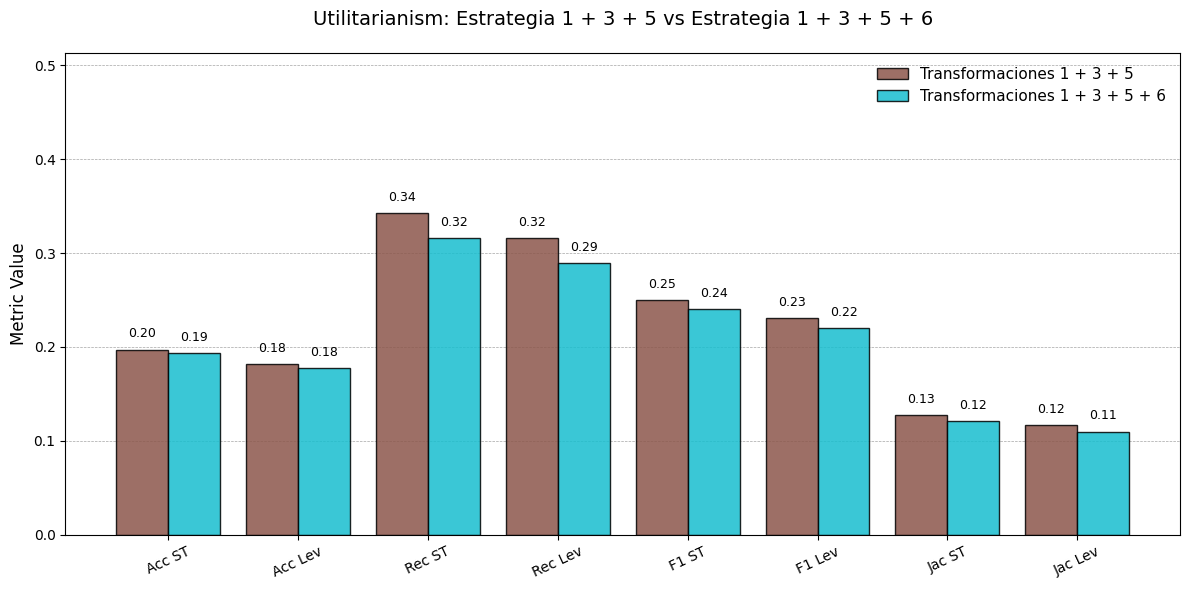

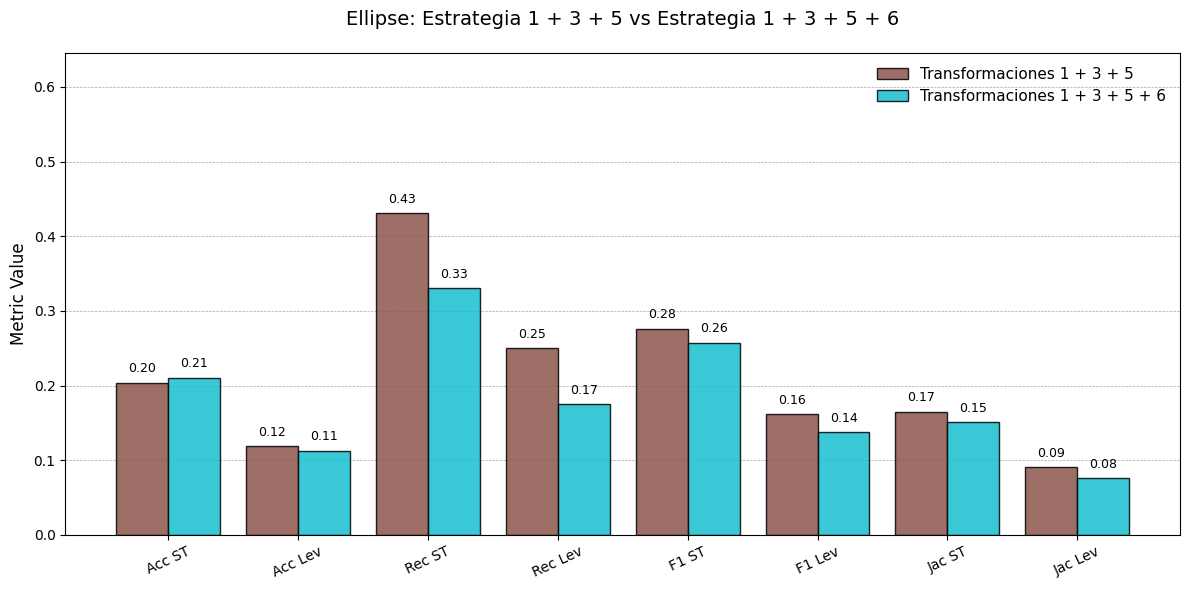

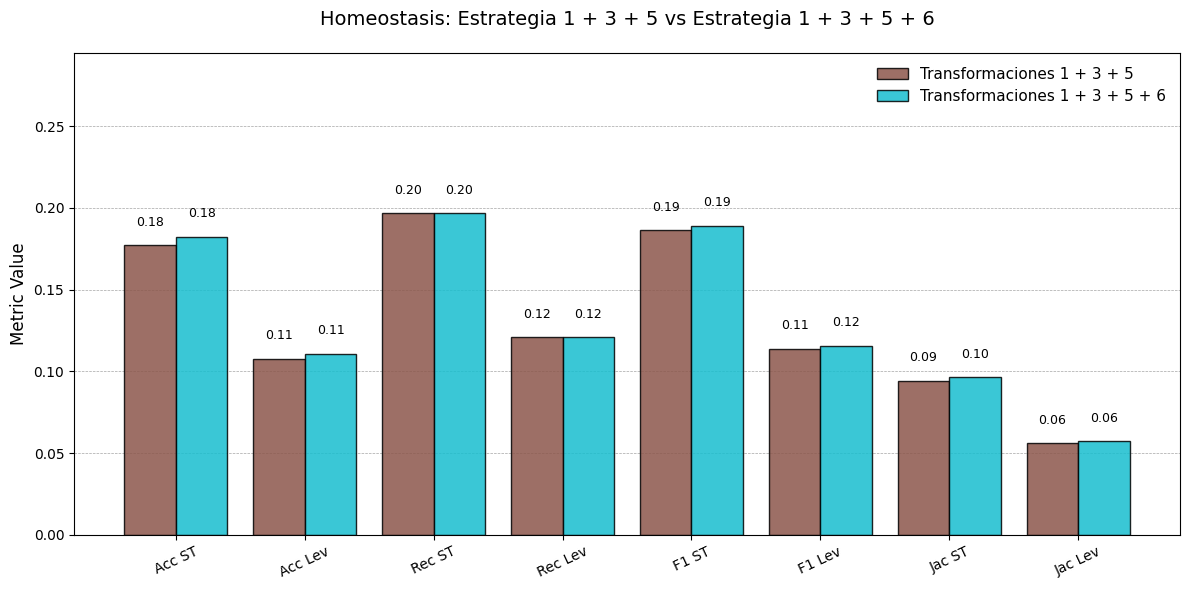

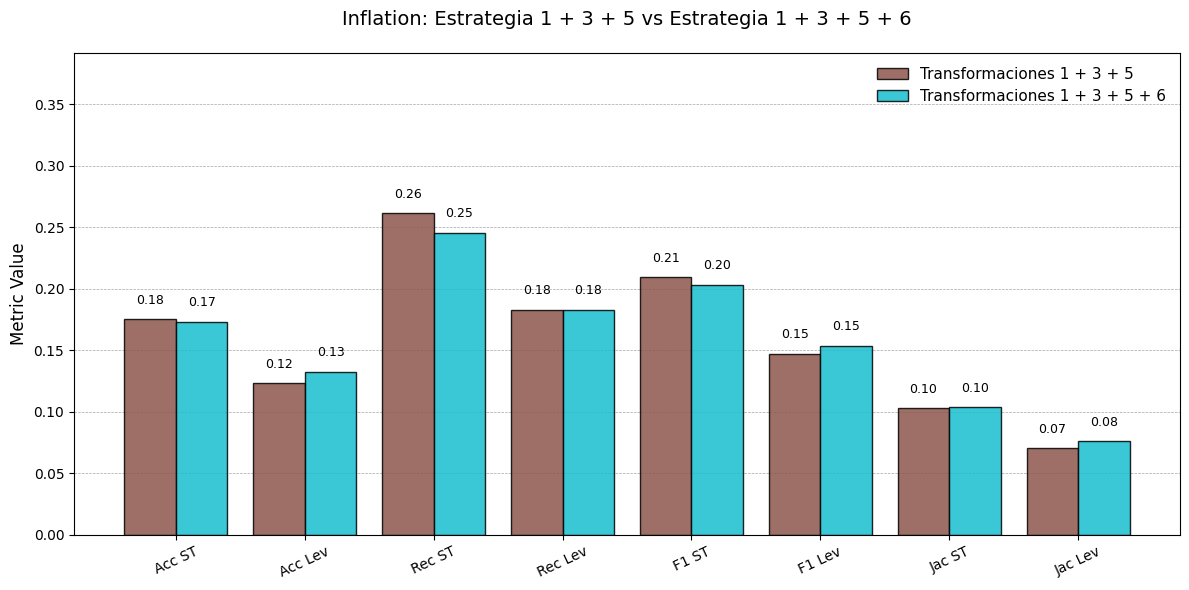

In [51]:
custom_colors = ['#8c564b', '#17becf']

plot_comparison_bars(df_utilitarianism_t1_t6, "Utilitarianism: Estrategia 1 + 3 + 5 vs Estrategia 1 + 3 + 5 + 6", colors=custom_colors)
plot_comparison_bars(df_ellipse_t1_t6,      "Ellipse: Estrategia 1 + 3 + 5 vs Estrategia 1 + 3 + 5 + 6",      colors=custom_colors)
plot_comparison_bars(df_homeostasis_t1_t6,  "Homeostasis: Estrategia 1 + 3 + 5 vs Estrategia 1 + 3 + 5 + 6",  colors=custom_colors)
plot_comparison_bars(df_inflation_t1_t6,    "Inflation: Estrategia 1 + 3 + 5 vs Estrategia 1 + 3 + 5 + 6",    colors=custom_colors)

In [52]:
df_utilitarianism_t1_t6

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.196970,0.181818,0.342105,0.315789,0.25,0.230769,0.127451,0.116505
1,Transformaciones 1 + 3 + 5 + 6,0.193548,0.177419,0.315789,0.289474,0.24,0.220000,0.121212,0.110000


In [53]:
df_ellipse_t1_t6

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.203571,0.119048,0.430556,0.250,0.276439,0.161290,0.165049,0.090909
1,Transformaciones 1 + 3 + 5 + 6,0.210753,0.112903,0.330556,0.175,0.257397,0.137255,0.151163,0.076087


In [54]:
df_homeostasis_t1_t6

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.177083,0.107639,0.196524,0.120766,0.186298,0.113825,0.094203,0.055944
1,Transformaciones 1 + 3 + 5 + 6,0.182298,0.110870,0.196524,0.120766,0.189144,0.115607,0.096296,0.057143


In [55]:
df_inflation_t1_t6

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.175287,0.123204,0.261364,0.183239,0.209841,0.147341,0.103030,0.070588
1,Transformaciones 1 + 3 + 5 + 6,0.173460,0.132639,0.245739,0.183239,0.203368,0.153886,0.103896,0.076433


#### Evolución media de métricas

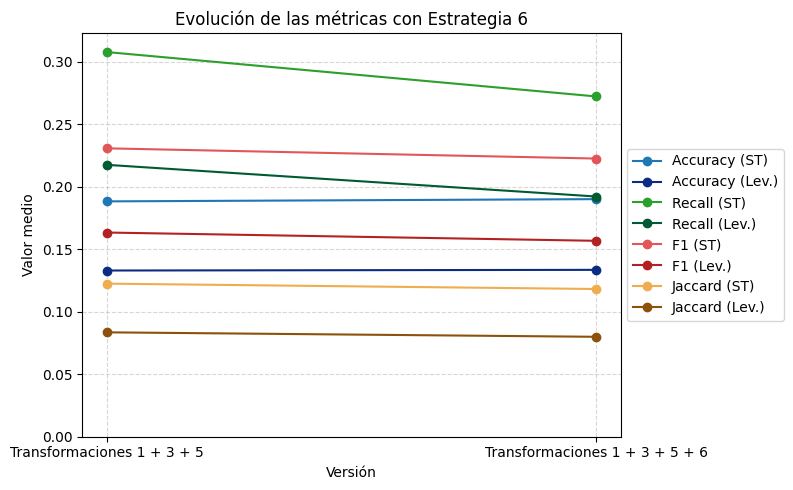

In [56]:
df_t1_t6_all = pd.concat([
    df_utilitarianism_t1_t6.assign(texto="Utilitarianism"),
    df_ellipse_t1_t6.assign(texto="Ellipse"),
    df_homeostasis_t1_t6.assign(texto="Homeostasis"),
    df_inflation_t1_t6.assign(texto="Inflation"),
], ignore_index=True)

df_t1_t6_summary = df_t1_t6_all.groupby("versión")[
    ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
].mean().reset_index()

metrics = [
    "accuracy_ST",
    "accuracy_Levenshtein",
    "recall_ST",
    "recall_Levenshtein",
    "f1_ST",
    "f1_Levenshtein",
    "jaccard_ST",
    "jaccard_Levenshtein"
]

labels = [
    "Accuracy (ST)",
    "Accuracy (Lev.)",
    "Recall (ST)",
    "Recall (Lev.)",
    "F1 (ST)",
    "F1 (Lev.)",
    "Jaccard (ST)",
    "Jaccard (Lev.)"
]

color_map = {
    "accuracy_ST":          "#1f77b4",
    "accuracy_Levenshtein": "#0c2c84",
    "recall_ST":            "#2ca02c",
    "recall_Levenshtein":   "#005a32",
    "f1_ST":                "#e15759",
    "f1_Levenshtein":       "#B22222",
    "jaccard_ST":           "#f0ad4e",
    "jaccard_Levenshtein":  "#8c510a"
}


metrics = list(color_map.keys())

order = ['Transformaciones 1 + 3 + 5', 'Transformaciones 1 + 3 + 5 + 6']
df_t1_t6_summary = df_t1_t6_summary.set_index('versión').loc[order].reset_index()

max_val = df_t1_t6_summary[metrics].max().max()

plt.figure(figsize=(8, 5))
for m, lbl in zip(metrics, labels):
    plt.plot(df_t1_t6_summary["versión"], df_t1_t6_summary[m], marker="o", label=lbl, color=color_map[m])


plt.ylim(0, max_val * 1.05)
plt.xlabel("Versión")
plt.ylabel("Valor medio")
plt.title("Evolución de las métricas con Estrategia 6")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [57]:
df_t1_t6_summary

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.188228,0.132927,0.307637,0.217449,0.230645,0.163306,0.122433,0.083487
1,Transformaciones 1 + 3 + 5 + 6,0.190015,0.133458,0.272152,0.192120,0.222477,0.156687,0.118142,0.079916


## Estrategia 7: Eliminación de tripletas similares

1. Eliminar tripletas duplicadas
2. Agrupar por sujeto y objeto y eliminar tripletas cuyo predicado está contenido en otro
3. Agrupar por sujeto y predicado y eliminar los objetos que están contenidos en otros objetos
4. Agrupar por predicado y objeto y eliminar los sujetos que están contenidos en otros sujetos


In [58]:
def remove_duplicate_triplets(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop_duplicates(subset=['sujeto', 'predicado', 'objeto'], keep='first').reset_index(drop=True)

def is_token_subsequence(short: List[str], long: List[str]) -> bool:
    it = iter(long)
    return all(tok in it for tok in short)

def filter_by_lexical_inclusion(df: pd.DataFrame) -> pd.DataFrame:
    kept = []
    for (s, o), group in df.groupby(['sujeto', 'objeto']):
        preds = group['predicado'].tolist()
        toks = [p.split() for p in preds]
        keep_idxs = []
        for i, t_i in enumerate(toks):
            if not any(j != i and len(toks[j]) > len(t_i) and is_token_subsequence(t_i, toks[j]) for j in range(len(toks))):
                keep_idxs.append(i)
        kept.extend(group.iloc[keep_idxs].to_dict('records'))
    return pd.DataFrame(kept, columns=df.columns)

def remove_subsumed_objects(df: pd.DataFrame) -> pd.DataFrame:
    records = []
    for (s, p), group in df.groupby(['sujeto', 'predicado']):
        objs = group['objeto'].tolist()
        keep = []
        for i, oi in enumerate(objs):
            if not any(oi != oj and oi in oj for oj in objs):
                keep.append(i)
        records.extend(group.iloc[keep].to_dict('records'))
    return pd.DataFrame(records, columns=df.columns)

def remove_subsumed_subjects(df: pd.DataFrame) -> pd.DataFrame:
    records = []
    for (p, o), group in df.groupby(['predicado', 'objeto']):
        subs = group['sujeto'].tolist()
        keep = []
        for i, si in enumerate(subs):
            if not any(si != sj and si in sj for sj in subs):
                keep.append(i)
        records.extend(group.iloc[keep].to_dict('records'))
    return pd.DataFrame(records, columns=df.columns)

def transform_pipeline(input_paths: List[str]) -> None:
    out_dir = "/content/Transformation_1_3_5_7"
    os.makedirs(out_dir, exist_ok=True)
    for in_path in input_paths:
        df = pd.read_csv(in_path, sep=';', quotechar='"')
        total_initial = len(df)
        df1 = remove_duplicate_triplets(df)
        df2 = filter_by_lexical_inclusion(df1)
        df3 = remove_subsumed_objects(df2)
        df4 = remove_subsumed_subjects(df3)
        total_final = len(df4)
        eliminated = total_initial - total_final
        base = os.path.splitext(os.path.basename(in_path))[0]
        filename = f"{base.replace('_Transformation_1_3_5', '')}_Transformation_1_3_5_7.csv"
        out_path = os.path.join(out_dir, filename)
        df4.to_csv(out_path, sep=';', index=False, quotechar='"', quoting=csv.QUOTE_ALL)
        print(f"Archivo: {in_path}")
        print(f"- Tripletas iniciales: {total_initial}")
        print(f"- Tripletas finales:   {total_final}")
        print(f"- Eliminadas:          {eliminated} ({eliminated/total_initial*100:.2f}% )")
        print(f"Guardado final: {in_path} → {out_path}\n")

csv_paths = [
    '/content/Utilitarianism_Transformation_1_3_5.csv',
    '/content/Ellipse_Transformation_1_3_5.csv',
    '/content/Homeostasis_Transformation_1_3_5.csv',
    '/content/Inflation_Transformation_1_3_5.csv'
]
transform_pipeline(csv_paths)

Archivo: /content/Utilitarianism_Transformation_1_3_5.csv
- Tripletas iniciales: 61
- Tripletas finales:   20
- Eliminadas:          41 (67.21% )
Guardado final: /content/Utilitarianism_Transformation_1_3_5.csv → /content/Transformation_1_3_5_7/Utilitarianism_Transformation_1_3_5_7.csv

Archivo: /content/Ellipse_Transformation_1_3_5.csv
- Tripletas iniciales: 60
- Tripletas finales:   27
- Eliminadas:          33 (55.00% )
Guardado final: /content/Ellipse_Transformation_1_3_5.csv → /content/Transformation_1_3_5_7/Ellipse_Transformation_1_3_5_7.csv

Archivo: /content/Homeostasis_Transformation_1_3_5.csv
- Tripletas iniciales: 58
- Tripletas finales:   21
- Eliminadas:          37 (63.79% )
Guardado final: /content/Homeostasis_Transformation_1_3_5.csv → /content/Transformation_1_3_5_7/Homeostasis_Transformation_1_3_5_7.csv

Archivo: /content/Inflation_Transformation_1_3_5.csv
- Tripletas iniciales: 120
- Tripletas finales:   36
- Eliminadas:          84 (70.00% )
Guardado final: /content

### Estrategia 7: Métricas

####  Análisis por texto

In [59]:
paths_t7 = {
    "utilitarianism": (
        "/content/Utilitarianism_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_7/Utilitarianism_Transformation_1_3_5_7.csv"
    ),
    "ellipse": (
        "/content/Ellipse_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_7/Ellipse_Transformation_1_3_5_7.csv"
    ),
    "homeostasis": (
        "/content/Homeostasis_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_7/Homeostasis_Transformation_1_3_5_7.csv"
    ),
    "inflation": (
        "/content/Inflation_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_7/Inflation_Transformation_1_3_5_7.csv"
    )
}

df_utilitarianism_t1_t7 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t7["utilitarianism"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t7["utilitarianism"][1], "Transformaciones 1 + 3 + 5 + 7")
], ignore_index=True)

df_ellipse_t1_t7 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t7["ellipse"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["ellipse"], paths_t7["ellipse"][1], "Transformaciones 1 + 3 + 5 + 7")
], ignore_index=True)

df_homeostasis_t1_t7 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t7["homeostasis"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t7["homeostasis"][1], "Transformaciones 1 + 3 + 5 + 7")
], ignore_index=True)

df_inflation_t1_t7 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t7["inflation"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["inflation"], paths_t7["inflation"][1], "Transformaciones 1 + 3 + 5 + 7")
], ignore_index=True)


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/s

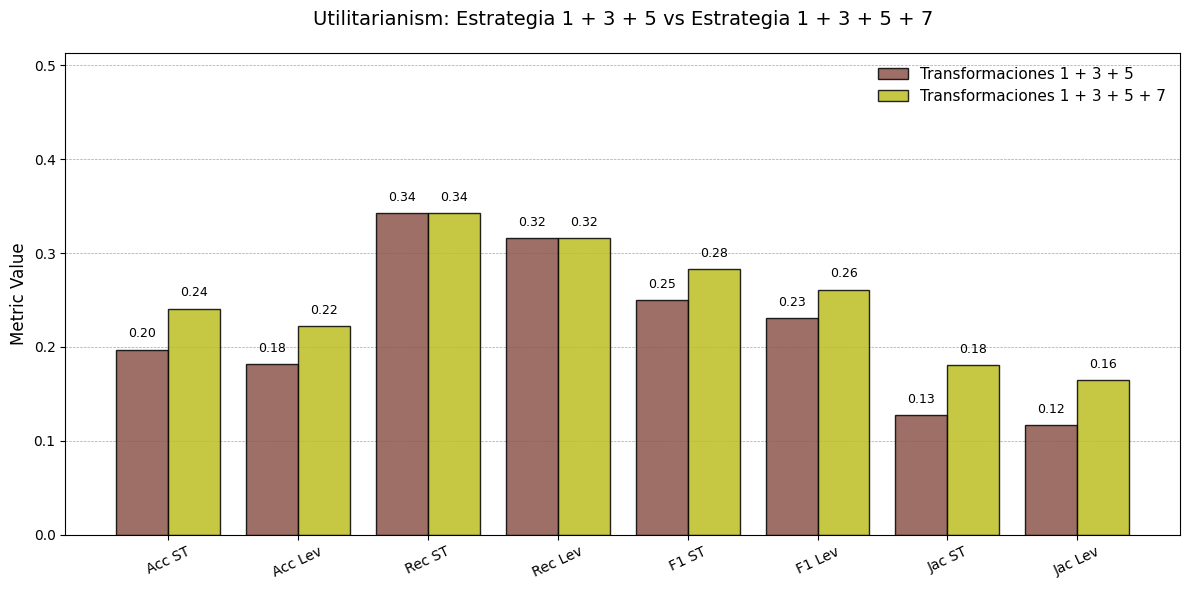

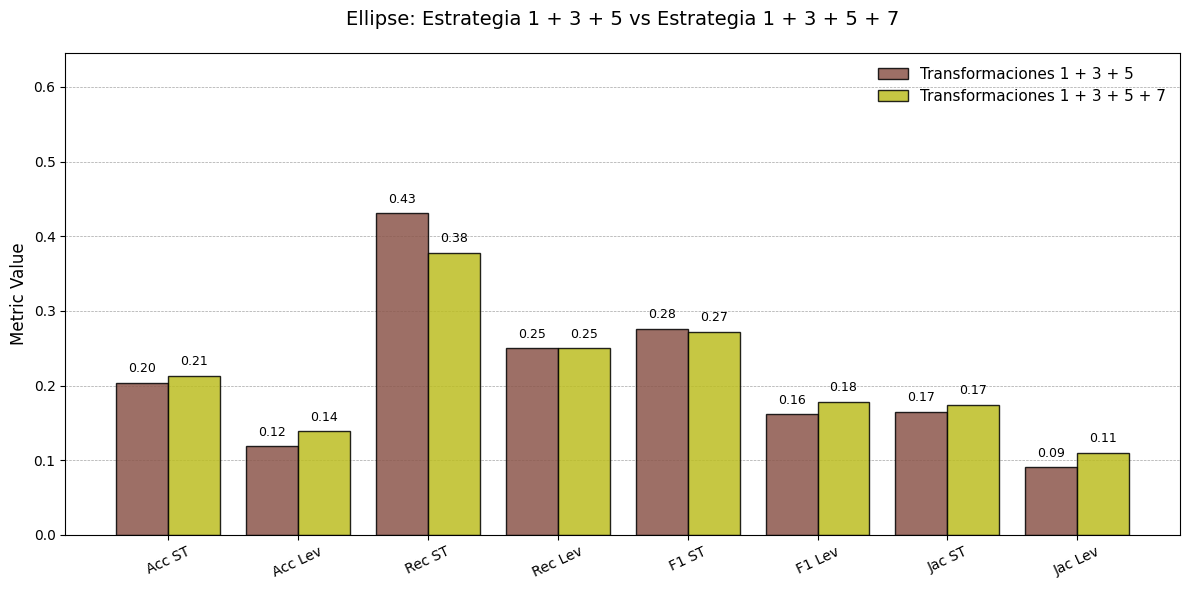

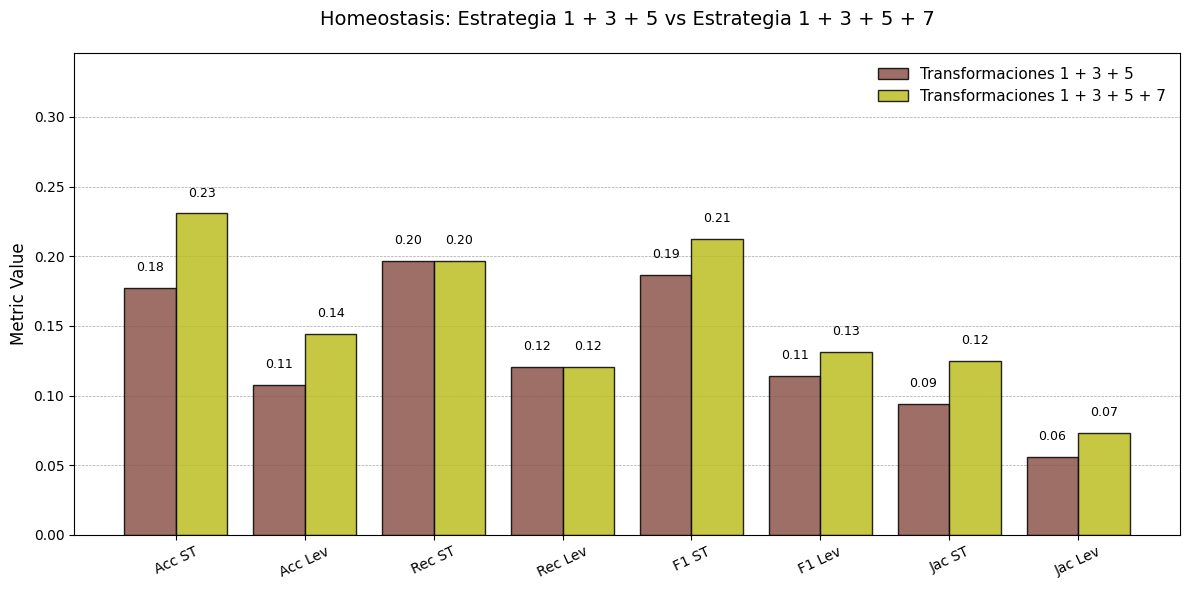

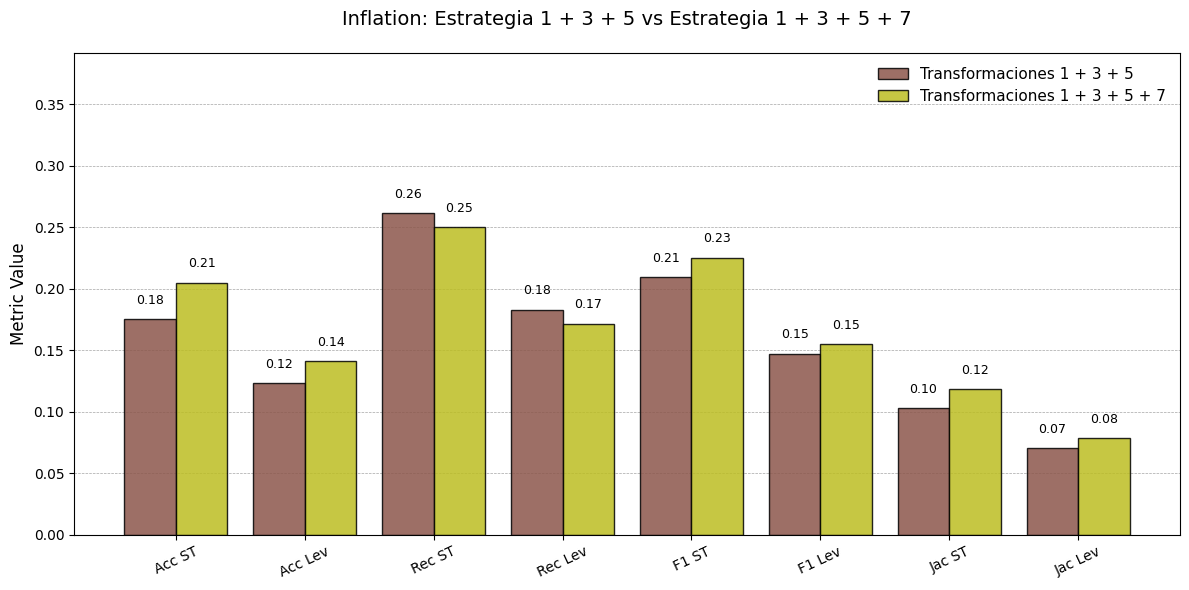

In [60]:
custom_colors = ['#8c564b', '#bcbd22']

plot_comparison_bars(df_utilitarianism_t1_t7, "Utilitarianism: Estrategia 1 + 3 + 5 vs Estrategia 1 + 3 + 5 + 7", colors=custom_colors)
plot_comparison_bars(df_ellipse_t1_t7,      "Ellipse: Estrategia 1 + 3 + 5 vs Estrategia 1 + 3 + 5 + 7",      colors=custom_colors)
plot_comparison_bars(df_homeostasis_t1_t7,  "Homeostasis: Estrategia 1 + 3 + 5 vs Estrategia 1 + 3 + 5 + 7",  colors=custom_colors)
plot_comparison_bars(df_inflation_t1_t7,    "Inflation: Estrategia 1 + 3 + 5 vs Estrategia 1 + 3 + 5 + 7",    colors=custom_colors)

In [61]:
df_utilitarianism_t1_t7

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.196970,0.181818,0.342105,0.315789,0.250000,0.230769,0.127451,0.116505
1,Transformaciones 1 + 3 + 5 + 7,0.240741,0.222222,0.342105,0.315789,0.282609,0.260870,0.180556,0.164384


In [62]:
df_ellipse_t1_t7

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.203571,0.119048,0.430556,0.25,0.276439,0.161290,0.165049,0.090909
1,Transformaciones 1 + 3 + 5 + 7,0.212963,0.138889,0.377778,0.25,0.272379,0.178571,0.174419,0.109890


In [63]:
df_homeostasis_t1_t7

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.177083,0.107639,0.196524,0.120766,0.186298,0.113825,0.094203,0.055944
1,Transformaciones 1 + 3 + 5 + 7,0.230706,0.144499,0.196524,0.120766,0.212248,0.131571,0.125000,0.073394


In [64]:
df_inflation_t1_t7

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.175287,0.123204,0.261364,0.183239,0.209841,0.147341,0.103030,0.070588
1,Transformaciones 1 + 3 + 5 + 7,0.205128,0.141026,0.250000,0.171875,0.225352,0.154930,0.118519,0.078571


#### Evolución media de métricas

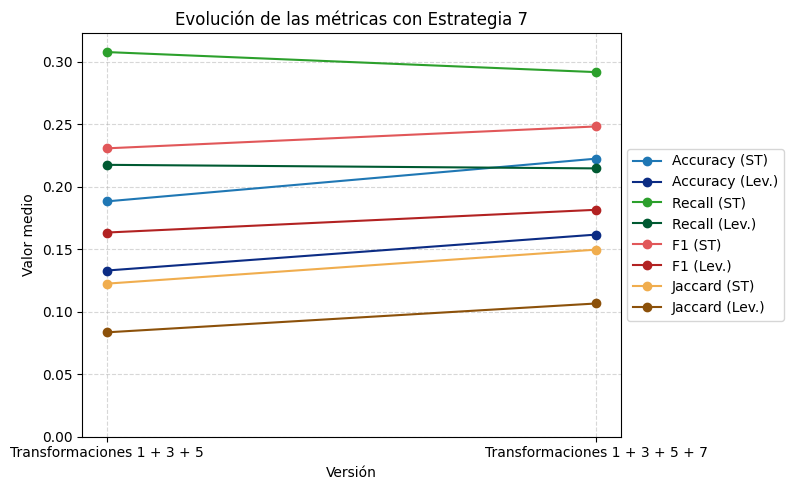

In [65]:
df_t1_t7_all = pd.concat([
    df_utilitarianism_t1_t7.assign(texto="Utilitarianism"),
    df_ellipse_t1_t7.assign(texto="Ellipse"),
    df_homeostasis_t1_t7.assign(texto="Homeostasis"),
    df_inflation_t1_t7.assign(texto="Inflation"),
], ignore_index=True)

df_t1_t7_summary = df_t1_t7_all.groupby("versión")[
    ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
].mean().reset_index()

metrics = [
    "accuracy_ST",
    "accuracy_Levenshtein",
    "recall_ST",
    "recall_Levenshtein",
    "f1_ST",
    "f1_Levenshtein",
    "jaccard_ST",
    "jaccard_Levenshtein"
]

labels = [
    "Accuracy (ST)",
    "Accuracy (Lev.)",
    "Recall (ST)",
    "Recall (Lev.)",
    "F1 (ST)",
    "F1 (Lev.)",
    "Jaccard (ST)",
    "Jaccard (Lev.)"
]

color_map = {
    "accuracy_ST":          "#1f77b4",
    "accuracy_Levenshtein": "#0c2c84",
    "recall_ST":            "#2ca02c",
    "recall_Levenshtein":   "#005a32",
    "f1_ST":                "#e15759",
    "f1_Levenshtein":       "#B22222",
    "jaccard_ST":           "#f0ad4e",
    "jaccard_Levenshtein":  "#8c510a"
}


metrics = list(color_map.keys())

order = ['Transformaciones 1 + 3 + 5', 'Transformaciones 1 + 3 + 5 + 7']
df_t1_t7_summary = df_t1_t7_summary.set_index('versión').loc[order].reset_index()

max_val = df_t1_t7_summary[metrics].max().max()

plt.figure(figsize=(8, 5))
for m, lbl in zip(metrics, labels):
    plt.plot(df_t1_t7_summary["versión"], df_t1_t7_summary[m], marker="o", label=lbl, color=color_map[m])


plt.ylim(0, max_val * 1.05)
plt.xlabel("Versión")
plt.ylabel("Valor medio")
plt.title("Evolución de las métricas con Estrategia 7")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [66]:
df_t1_t7_summary

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.188228,0.132927,0.307637,0.217449,0.230645,0.163306,0.122433,0.083487
1,Transformaciones 1 + 3 + 5 + 7,0.222384,0.161659,0.291602,0.214608,0.248147,0.181485,0.149623,0.106560


## Evaluación Bloque III

Transformaciones 1 + 3 + 5 + 6 + 7

In [67]:
def transform_pipeline(input_dir: str, output_dir: str) -> None:
    os.makedirs(output_dir, exist_ok=True)

    for fname in os.listdir(input_dir):
        if not fname.endswith('.csv'):
            continue
        in_path = os.path.join(input_dir, fname)
        df = pd.read_csv(in_path, sep=';', quotechar='"')
        total_initial = len(df)

        df1 = remove_duplicate_triplets(df)
        df2 = filter_by_lexical_inclusion(df1)
        df3 = remove_subsumed_objects(df2)
        df4 = remove_subsumed_subjects(df3)

        total_final = len(df4)
        eliminated = total_initial - total_final
        pct_elim = (eliminated / total_initial * 100) if total_initial else 0

        base = os.path.splitext(fname)[0]
        name_no_suffix = base.replace('_Transformation_1_3_5_6', '')
        out_name = f"{name_no_suffix}_Transformation_1_3_5_6_7.csv"
        out_path = os.path.join(output_dir, out_name)

        df4.to_csv(out_path, sep=';', index=False, quotechar='"', quoting=csv.QUOTE_ALL)

        print(f"Archivo: {in_path}")
        print(f"- Tripletas iniciales: {total_initial}")
        print(f"- Tripletas finales:   {total_final}")
        print(f"- Eliminadas:          {eliminated} ({pct_elim:.2f}% )")
        print(f"Guardado final: {in_path} → {out_path}\n")

input_dir = '/content/Transformation_1_3_5_6'
output_dir = '/content/Transformation_1_3_5_6_7'
transform_pipeline(input_dir, output_dir)

Archivo: /content/Transformation_1_3_5_6/Inflation_Transformation_1_3_5_6.csv
- Tripletas iniciales: 109
- Tripletas finales:   30
- Eliminadas:          79 (72.48% )
Guardado final: /content/Transformation_1_3_5_6/Inflation_Transformation_1_3_5_6.csv → /content/Transformation_1_3_5_6_7/Inflation_Transformation_1_3_5_6_7.csv

Archivo: /content/Transformation_1_3_5_6/Ellipse_Transformation_1_3_5_6.csv
- Tripletas iniciales: 48
- Tripletas finales:   19
- Eliminadas:          29 (60.42% )
Guardado final: /content/Transformation_1_3_5_6/Ellipse_Transformation_1_3_5_6.csv → /content/Transformation_1_3_5_6_7/Ellipse_Transformation_1_3_5_6_7.csv

Archivo: /content/Transformation_1_3_5_6/Homeostasis_Transformation_1_3_5_6.csv
- Tripletas iniciales: 56
- Tripletas finales:   20
- Eliminadas:          36 (64.29% )
Guardado final: /content/Transformation_1_3_5_6/Homeostasis_Transformation_1_3_5_6.csv → /content/Transformation_1_3_5_6_7/Homeostasis_Transformation_1_3_5_6_7.csv

Archivo: /content/

In [68]:
paths_t1_t3_t5_t6_t7 = {
    "utilitarianism": (
        "/content/Utilitarianism_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_6_7/Utilitarianism_Transformation_1_3_5_6_7.csv"
    ),
    "ellipse": (
        "/content/Ellipse_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_6_7/Ellipse_Transformation_1_3_5_6_7.csv"
    ),
    "homeostasis": (
        "/content/Homeostasis_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_6_7/Homeostasis_Transformation_1_3_5_6_7.csv"
    ),
    "inflation": (
        "/content/Inflation_Transformation_1_3_5.csv",
        "/content/Transformation_1_3_5_6_7/Inflation_Transformation_1_3_5_6_7.csv"
    )
}

df_utilitarianism_t1_t3_t5_t6_t7 = pd.concat([
    evaluar_grafo(gold_paths["utilitarianism"], paths_t1_t3_t5_t6_t7["utilitarianism"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["utilitarianism"], paths_t1_t3_t5_t6_t7["utilitarianism"][1], "Transformaciones 1 + 3 + 5 + 6 + 7")
], ignore_index=True)

df_ellipse_t1_t3_t5_t6_t7 = pd.concat([
    evaluar_grafo(gold_paths["ellipse"], paths_t1_t3_t5_t6_t7["ellipse"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["ellipse"], paths_t1_t3_t5_t6_t7["ellipse"][1], "Transformaciones 1 + 3 + 5 + 6 + 7")
], ignore_index=True)

df_homeostasis_t1_t3_t5_t6_t7 = pd.concat([
    evaluar_grafo(gold_paths["homeostasis"], paths_t1_t3_t5_t6_t7["homeostasis"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["homeostasis"], paths_t1_t3_t5_t6_t7["homeostasis"][1], "Transformaciones 1 + 3 + 5 + 6 + 7")
], ignore_index=True)

df_inflation_t1_t3_t5_t6_t7 = pd.concat([
    evaluar_grafo(gold_paths["inflation"], paths_t1_t3_t5_t6_t7["inflation"][0], "Transformaciones 1 + 3 + 5"),
    evaluar_grafo(gold_paths["inflation"], paths_t1_t3_t5_t6_t7["inflation"][1], "Transformaciones 1 + 3 + 5 + 6 + 7")
], ignore_index=True)

HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/s

In [69]:
df_inflation_t1_t3_t5_t6_t7

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.175287,0.123204,0.261364,0.183239,0.209841,0.147341,0.103030,0.070588
1,Transformaciones 1 + 3 + 5 + 6 + 7,0.197368,0.148649,0.234375,0.171875,0.214286,0.159420,0.116279,0.083333


####  Análisis por texto

In [70]:
# Utilitarianism
df_utilitarianism_combined = pd.concat([
    df_utilitarianism_t1_t6,
    df_utilitarianism_t1_t7,
    df_utilitarianism_t1_t3_t5_t6_t7,
], ignore_index=True).drop_duplicates(subset='versión')
utilitarianism_order = [
    'Transformaciones 1 + 3 + 5',
    'Transformaciones 1 + 3 + 5 + 6',
    'Transformaciones 1 + 3 + 5 + 7',
    'Transformaciones 1 + 3 + 5 + 6 + 7',
]
df_utilitarianism = (
    df_utilitarianism_combined
    .set_index('versión')
    .loc[utilitarianism_order]
    .reset_index()
)

# Ellipse
df_ellipse_combined = pd.concat([
    df_ellipse_t1_t6,
    df_ellipse_t1_t7,
    df_ellipse_t1_t3_t5_t6_t7,
], ignore_index=True).drop_duplicates(subset='versión')
ellipse_order = [
    'Transformaciones 1 + 3 + 5',
    'Transformaciones 1 + 3 + 5 + 6',
    'Transformaciones 1 + 3 + 5 + 7',
    'Transformaciones 1 + 3 + 5 + 6 + 7',
]
df_ellipse = (
    df_ellipse_combined
    .set_index('versión')
    .loc[ellipse_order]
    .reset_index()
)

# Homeostasis
df_homeostasis_combined = pd.concat([
    df_homeostasis_t1_t6,
    df_homeostasis_t1_t7,
    df_homeostasis_t1_t3_t5_t6_t7,
], ignore_index=True).drop_duplicates(subset='versión')
homeostasis_order = [
    'Transformaciones 1 + 3 + 5',
    'Transformaciones 1 + 3 + 5 + 6',
    'Transformaciones 1 + 3 + 5 + 7',
    'Transformaciones 1 + 3 + 5 + 6 + 7',
]
df_homeostasis = (
    df_homeostasis_combined
    .set_index('versión')
    .loc[homeostasis_order]
    .reset_index()
)

# Inflation
df_inflation_combined = pd.concat([
    df_inflation_t1_t6,
    df_inflation_t1_t7,
    df_inflation_t1_t3_t5_t6_t7,
], ignore_index=True).drop_duplicates(subset='versión')
inflation_order = [
    'Transformaciones 1 + 3 + 5',
    'Transformaciones 1 + 3 + 5 + 6',
    'Transformaciones 1 + 3 + 5 + 7',
    'Transformaciones 1 + 3 + 5 + 6 + 7',
]
df_inflation = (
    df_inflation_combined
    .set_index('versión')
    .loc[inflation_order]
    .reset_index()
)


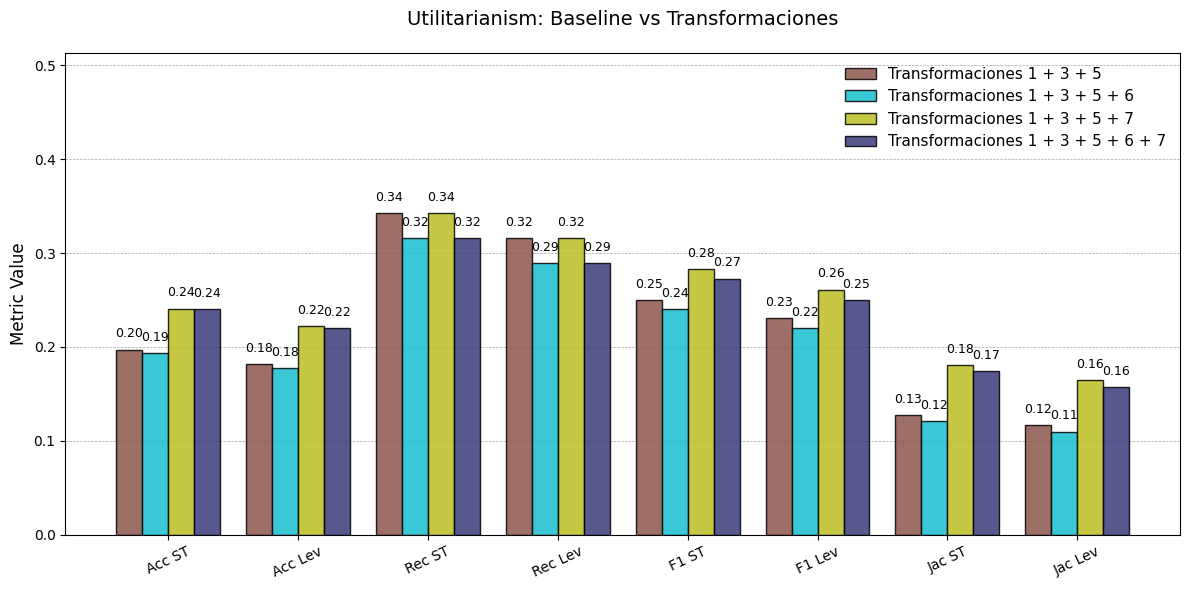

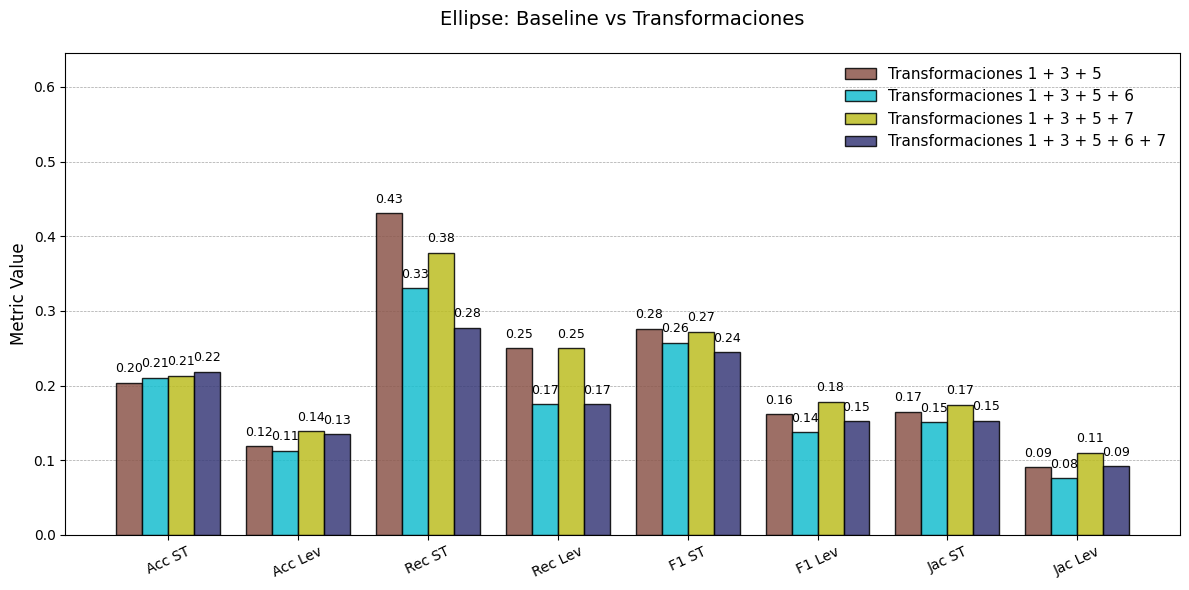

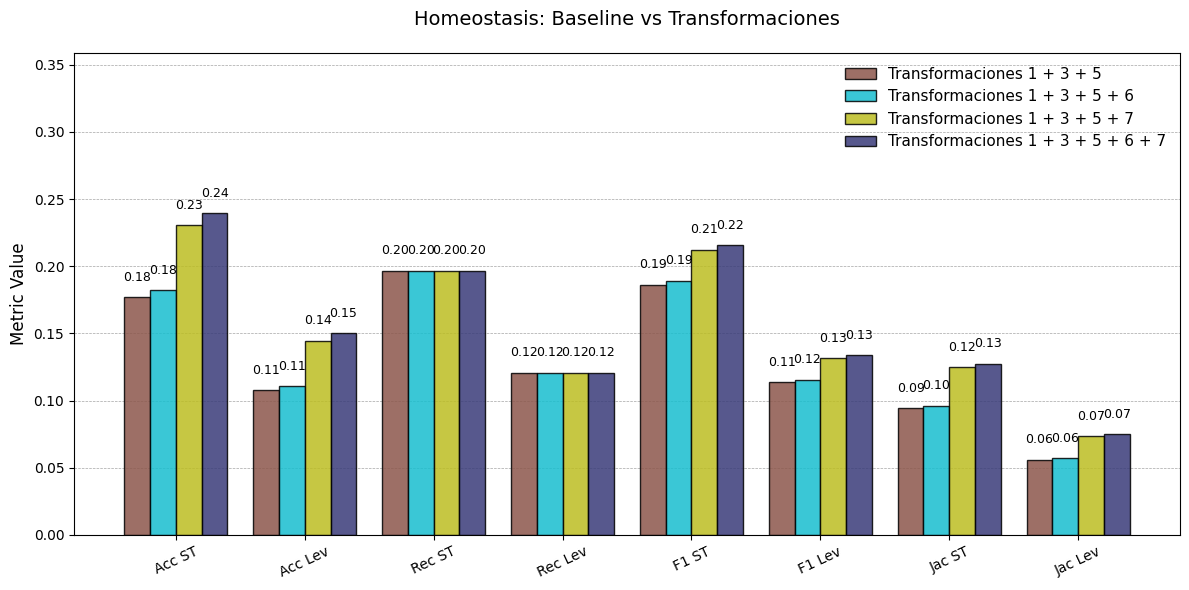

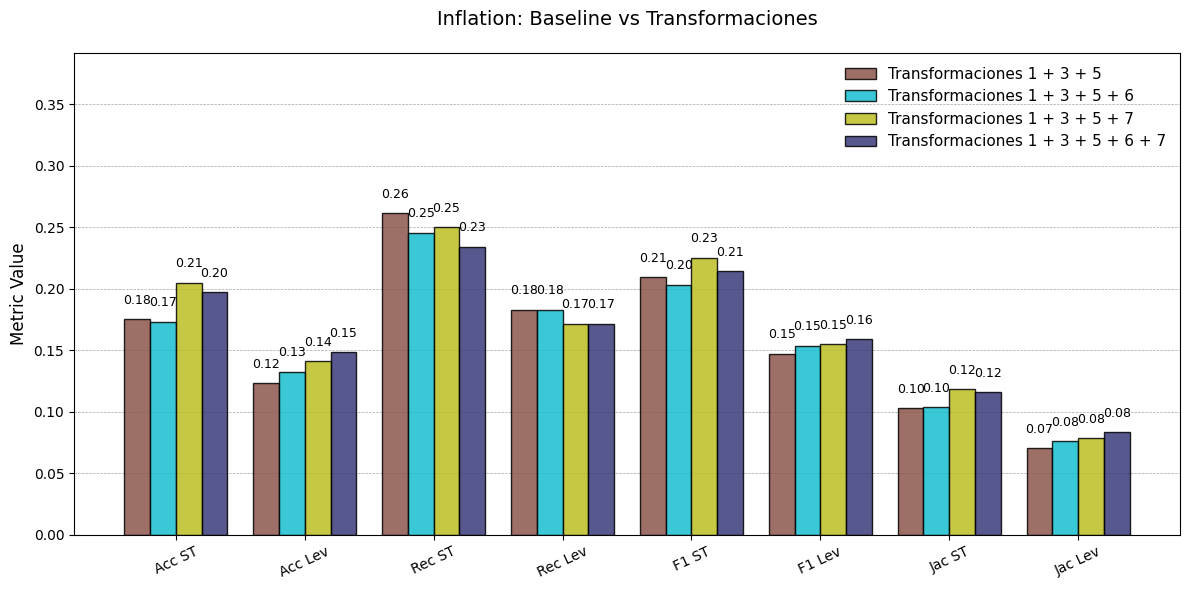

In [71]:
custom_colors = ['#8c564b', '#17becf', '#bcbd22', '#393b79']

plot_comparison_bars(df_utilitarianism, "Utilitarianism: Baseline vs Transformaciones", colors=custom_colors)
plot_comparison_bars(df_ellipse, "Ellipse: Baseline vs Transformaciones", colors=custom_colors)
plot_comparison_bars(df_homeostasis, "Homeostasis: Baseline vs Transformaciones", colors=custom_colors)
plot_comparison_bars(df_inflation, "Inflation: Baseline vs Transformaciones", colors=custom_colors)

#### Evolución media de métricas

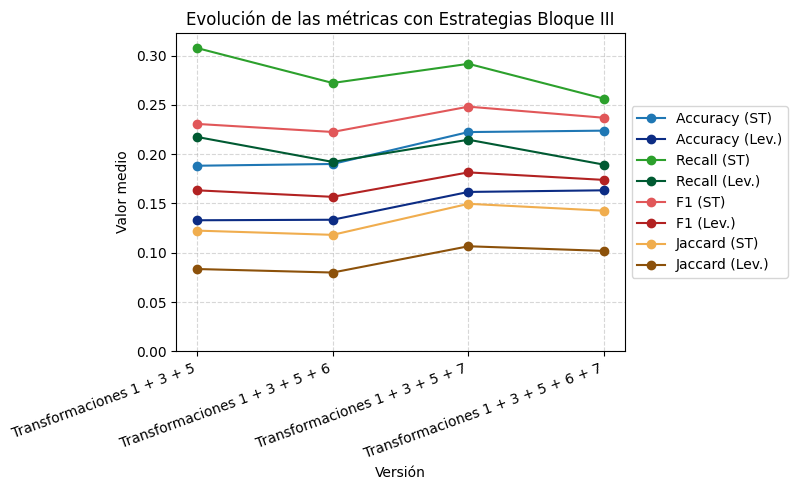

In [72]:
df_all = pd.concat([
    df_utilitarianism.assign(texto="Utilitarianism"),
    df_ellipse.assign(texto="Ellipse"),
    df_homeostasis.assign(texto="Homeostasis"),
    df_inflation.assign(texto="Inflation"),
], ignore_index=True)

df_summary = df_all.groupby("versión")[
    ["accuracy_ST","accuracy_Levenshtein",
     "recall_ST","recall_Levenshtein",
     "f1_ST", "f1_Levenshtein",
     "jaccard_ST","jaccard_Levenshtein"]
].mean().reset_index()

order = [
    'Transformaciones 1 + 3 + 5',
    'Transformaciones 1 + 3 + 5 + 6',
    'Transformaciones 1 + 3 + 5 + 7',
    'Transformaciones 1 + 3 + 5 + 6 + 7'
]
df_summary = df_summary.set_index('versión').loc[order].reset_index()

metrics = [
    "accuracy_ST",
    "accuracy_Levenshtein",
    "recall_ST",
    "recall_Levenshtein",
    "f1_ST",
    "f1_Levenshtein",
    "jaccard_ST",
    "jaccard_Levenshtein"
]

labels = [
    "Accuracy (ST)",
    "Accuracy (Lev.)",
    "Recall (ST)",
    "Recall (Lev.)",
    "F1 (ST)",
    "F1 (Lev.)",
    "Jaccard (ST)",
    "Jaccard (Lev.)"
]

max_val = df_summary[metrics].max().max()

plt.figure(figsize=(8, 5))
for m, lbl in zip(metrics, labels):
    plt.plot(df_summary["versión"], df_summary[m], marker="o", label=lbl, color=color_map[m])

plt.ylim(0, max_val * 1.05)
plt.xlabel("Versión")
plt.ylabel("Valor medio")
plt.title("Evolución de las métricas con Estrategias Bloque III")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()


In [73]:
df_summary

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,f1_ST,f1_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Transformaciones 1 + 3 + 5,0.188228,0.132927,0.307637,0.217449,0.230645,0.163306,0.122433,0.083487
1,Transformaciones 1 + 3 + 5 + 6,0.190015,0.133458,0.272152,0.192120,0.222477,0.156687,0.118142,0.079916
2,Transformaciones 1 + 3 + 5 + 7,0.222384,0.161659,0.291602,0.214608,0.248147,0.181485,0.149623,0.106560
3,Transformaciones 1 + 3 + 5 + 6 + 7,0.223819,0.163316,0.256117,0.189279,0.236874,0.173850,0.142605,0.101837


In [74]:
to_save = {
    'utilitarianism_bloque_III_evaluation.csv': df_utilitarianism,
    'ellipse_bloque_III_evaluation.csv':        df_ellipse,
    'homeostasis_bloque_III_evaluation.csv':    df_homeostasis,
    'inflation_bloque_III_evaluation.csv':      df_inflation,
    'summary_bloque_III_evaluation.csv':        df_summary,
}

for filename, df in to_save.items():
    df.to_csv(filename, index=False)
    print(f"Guardado: {filename}")

Guardado: utilitarianism_bloque_III_evaluation.csv
Guardado: ellipse_bloque_III_evaluation.csv
Guardado: homeostasis_bloque_III_evaluation.csv
Guardado: inflation_bloque_III_evaluation.csv
Guardado: summary_bloque_III_evaluation.csv
